# Загрузка Order book из CSV

In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Скоростная загрузка с диска, из заархивированного CSV-файла

In [2]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [3]:
# загрузка истории
# 15 секунд
# db = Database()
# sql_history = f"select * from v_history with (snapshot) where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
# df_history = db.query(sql_history)
# df_history.set_index('dt', inplace=True)

### Немного статистики по загруженным датасетам

In [4]:
order.describe()

,exchange,pair,bid_ask,price,amount,volume
count,153400,153400,153400,153400,153400,153400
unique,1,1,2,1509,22817,29503
top,binance,ETH/USDT,ask,232,1,"10,06027"
freq,153400,153400,76700,682,3122,500


In [5]:
len(order.index.sort_values().unique())

767

In [6]:
#len(df_history)

In [7]:
order.head()

,exchange,pair,bid_ask,price,amount,volume
dt,,,,,,
2018-10-01 14:54:05.000,binance,ETH/USDT,ask,"232,09","0,37381","86,75756"
2018-10-01 14:54:05.000,binance,ETH/USDT,ask,"231,88","130,7008","30306,91"
2018-10-01 14:54:05.000,binance,ETH/USDT,ask,"231,82","2,41816","560,5779"
2018-10-01 14:54:05.000,binance,ETH/USDT,ask,"231,59","0,3","69,47701"
2018-10-01 14:54:05.000,binance,ETH/USDT,ask,"231,96","0,45707","106,022"


In [8]:
# конвертация dt в time во временном формате

order.reset_index(inplace=True)
import datetime
order['time'] = pd.to_datetime(order.dt)
order.set_index('time',inplace=True)

In [9]:
# конвертация цены, кол-ва и объема в числа

order.price = order.price.str.replace(',', '.')
order.amount = order.amount.str.replace(',', '.')
order.volume = order.volume.str.replace(',', '.')

order.price = order.price.astype(float)
order.amount = order.amount.astype(float)
order.volume = order.volume.astype(float)

In [10]:
order.dtypes

dt           object
exchange     object
pair         object
bid_ask      object
price       float64
amount      float64
volume      float64
dtype: object

In [11]:
order['2018-09-29 00:00:00':'2018-09-30 16:00:00'][['amount', 'volume', 'bid_ask']].resample('T').sum()

,amount,volume
time,,
2018-09-29 16:50:00,3379.11325,7.793026e+05
2018-09-29 16:51:00,3559.15487,8.207185e+05
2018-09-29 16:52:00,0.00000,0.000000e+00
2018-09-29 16:53:00,0.00000,0.000000e+00
2018-09-29 16:54:00,0.00000,0.000000e+00
2018-09-29 16:55:00,0.00000,0.000000e+00
2018-09-29 16:56:00,0.00000,0.000000e+00
2018-09-29 16:57:00,7153.93471,1.650878e+06
2018-09-29 16:58:00,0.00000,0.000000e+00


In [12]:
order.describe()

,price,amount,volume
count,153400.000000,153400.000000,153400.000000
mean,231.109536,16.044408,3710.305383
std,2.716924,44.558045,10327.643388
min,224.430000,0.000010,0.002285
25%,228.920000,0.253270,59.054490
50%,230.990000,2.234340,518.156650
75%,232.550000,12.000000,2773.792000
max,240.880000,3709.355000,843878.300000


TypeError: unsupported operand type(s) for /: 'float' and 'AxesSubplot'

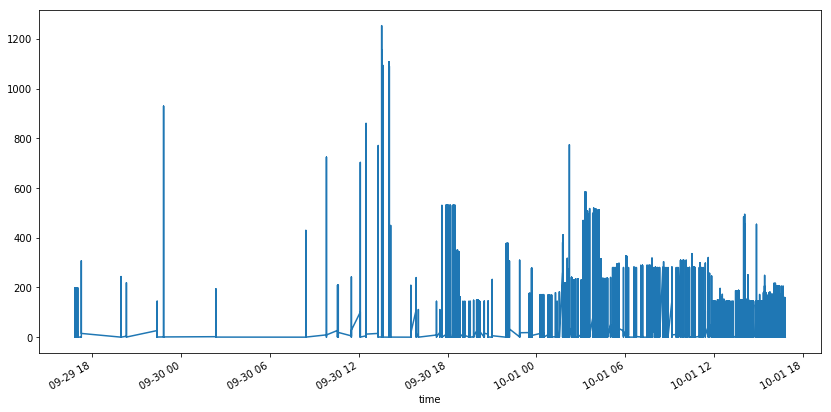

In [13]:
#order.volume[order.bid_ask == 'ask'] / order.amount[order.bid_ask == 'ask'].plot(figsize=(14,7))
#print((order.volume[order.bid_ask == 'bid'] / order.amount[order.bid_ask == 'bid']).mean())#plot(figsize=(14,7))

In [ ]:
#order['2018-09-30 00:00:00':'2018-09-30 08:26:00'][['amount', 'volume', 'bid_ask']].resample('T').sum()

In [28]:
order['2018-10-01 00:20:00':'2018-10-01 0:23:00'].volume#.plot(figsize=(13,7))

Series([], Name: volume, dtype: float64)

In [29]:
order.sort_values('dt').tail()

,index,dt,exchange,pair,bid_ask,price,amount,volume
time,,,,,,,,
2018-10-01 16:47:32,51566,2018-10-01 16:47:32.000,binance,ETH/USDT,bid,228.92,0.25797,59.05449
2018-10-01 16:47:32,51565,2018-10-01 16:47:32.000,binance,ETH/USDT,ask,229.57,3.25000,746.10250
2018-10-01 16:47:32,51564,2018-10-01 16:47:32.000,binance,ETH/USDT,bid,228.49,76.00000,17365.24000
2018-10-01 16:47:32,51574,2018-10-01 16:47:32.000,binance,ETH/USDT,bid,228.30,53.18878,12143.00000
2018-10-01 16:47:32,51438,2018-10-01 16:47:32.000,binance,ETH/USDT,ask,231.55,2.31331,535.64690
